In [1]:
import numpy as np 
import pandas as pd 
pd.set_option('display.max_colwidth', -1)
from time import time
import re
import string
import os
import emoji
import itertools
import nltk
import stats
import pickle
from pprint import pprint
import collections
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")
sns.set(font_scale=1.3)
from autocorrect import Speller
from textblob import TextBlob
from lightgbm import LGBMClassifier
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import AdaBoostClassifier,RandomForestClassifier,ExtraTreesClassifier
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer, TfidfTransformer
from sklearn.model_selection import GridSearchCV,train_test_split,RandomizedSearchCV,KFold,StratifiedKFold
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.metrics import classification_report,f1_score
from sklearn.naive_bayes import MultinomialNB, GaussianNB, BernoulliNB
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.externals import joblib
from sklearn.svm import SVC,LinearSVC
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import xgboost as xgb
import gensim
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.classify import SklearnClassifier

from wordcloud import WordCloud,STOPWORDS
from contractions import CONTRACTION_MAP
import warnings
warnings.filterwarnings('ignore')
np.random.seed(37)
%matplotlib inline

eng_stopwords = set(stopwords.words("english"))
pd.options.mode.chained_assignment = None

C:\Users\gaurav.singh.rawal\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\gaurav.singh.rawal\Anaconda3\lib\site-packages\sklearn\externals\joblib\__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [2]:
train_data=pd.read_csv(r"C:\Users\gaurav.singh.rawal\Documents\Gaurav\Data Science\Machine Learning-Predictive Analytics\ML-Projects\GIT - ML - Projects\ML_Projects\NLP - Sentiment Analysis\AnalyticsVidhya - Mobile Customer Feedback\train.csv")
test_data=pd.read_csv(r"C:\Users\gaurav.singh.rawal\Documents\Gaurav\Data Science\Machine Learning-Predictive Analytics\ML-Projects\GIT - ML - Projects\ML_Projects\NLP - Sentiment Analysis\AnalyticsVidhya - Mobile Customer Feedback\test.csv")

In [3]:
train_data.head()

,id,label,tweet
0,1,0,#fingerprint #Pregnancy Test https://goo.gl/h1MfQV #android #apps #beautiful #cute #health #igers #iphoneonly #iphonesia #iphone
1,2,0,Finally a transparant silicon case ^^ Thanks to my uncle :) #yay #Sony #Xperia #S #sonyexperias… http://instagram.com/p/YGEt5JC6JM/
2,3,0,We love this! Would you go? #talk #makememories #unplug #relax #iphone #smartphone #wifi #connect... http://fb.me/6N3LsUpCu
3,4,0,I'm wired I know I'm George I was made that way ;) #iphone #cute #daventry #home http://instagr.am/p/Li_5_ujS4k/
4,5,1,What amazing service! Apple won't even talk to me about a question I have unless I pay them $19.95 for their stupid support!


In [4]:
test_data.shape

(1953, 2)

In [5]:
temp = train_data.groupby('label').count()['tweet'].reset_index().sort_values(by='tweet',ascending=False)
temp.style.background_gradient(cmap='Purples')

,label,tweet
0,0,5894
1,1,2026


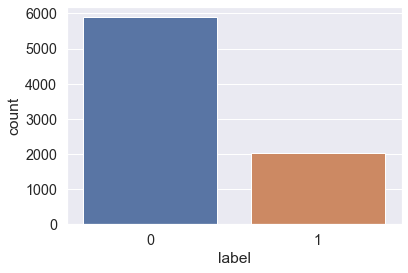

In [6]:
sns.countplot(x='label',data=train_data)

In [7]:
def expand_contractions(text, contraction_mapping=CONTRACTION_MAP):
    
    contractions_pattern = re.compile('({})'.format('|'.join(contraction_mapping.keys())), 
                                      flags=re.IGNORECASE|re.DOTALL)
    def expand_match(contraction):
        match = contraction.group(0)
        first_char = match[0]
        expanded_contraction = contraction_mapping.get(match)\
                                if contraction_mapping.get(match)\
                                else contraction_mapping.get(match.lower())                       
        expanded_contraction = first_char+expanded_contraction[1:]
        return expanded_contraction
        
    expanded_text = contractions_pattern.sub(expand_match, text)
    expanded_text = re.sub("'", "", expanded_text)
    return expanded_text

In [8]:
train_data['tweet']=train_data['tweet'].apply(expand_contractions)
test_data['tweet']=test_data['tweet'].apply(expand_contractions)

In [9]:
train_data.head()

,id,label,tweet
0,1,0,#fingerprint #Pregnancy Test https://goo.gl/h1MfQV #android #apps #beautiful #cute #health #igers #iphoneonly #iphonesia #iphone
1,2,0,Finally a transparant silicon case ^^ Thanks to my uncle :) #yay #Sony #Xperia #S #sonyexperias… http://instagram.com/p/YGEt5JC6JM/
2,3,0,We love this! Would you go? #talk #makememories #unplug #relax #iphone #smartphone #wifi #connect... http://fb.me/6N3LsUpCu
3,4,0,I am wired I know I am George I was made that way ;) #iphone #cute #daventry #home http://instagr.am/p/Li_5_ujS4k/
4,5,1,What amazing service! Apple will not even talk to me about a question I have unless I pay them $19.95 for their stupid support!


In [10]:
class CleanText(BaseEstimator, TransformerMixin):
    def remove_mentions(self, input_text):
        return re.sub(r'@\w+', '', input_text)
    
    def remove_urls(self, input_text):
        return re.sub(r'http.?://[^\s]+[\s]?', '', input_text)
    
    def emoji_oneword(self, input_text):
        # By compressing the underscore, the emoji is kept as one word
        return input_text.replace('_','')
    
    def remove_punctuation(self, input_text):
        # Make translation table
        punct = string.punctuation
        trantab = str.maketrans(punct, len(punct)*' ')  # Every punctuation symbol will be replaced by a space
        return input_text.translate(trantab)
    def remove_digits(self, input_text):
        return re.sub('\d+', '', input_text)
    
    def split_words(self,input_text):
        return ''.join(re.findall('[A-Z][^A-Z]*', input_text))
    
    def standardize_words(self,input_text):
        return ''.join(''.join(s)[:2] for _, s in itertools.groupby(input_text))
    
    def to_lower(self, input_text):
        return input_text.lower()
    
    '''def correct_spell(self,input_text):
        words = input_text.split() 
        clean_words = [str(TextBlob(word).correct()) for word in words] 
        return " ".join(clean_words)'''
    
    """def correct_spell(self,input_text):
        words = input_text.split() 
        spell = Speller(lang='en') 
        correct_words = [spell(word) for word in words] 
        return " ".join(correct_words) """
    '''def remove_meaningless(self,input_text):
        words = set(nltk.corpus.words.words())
        return " ".join(w for w in nltk.wordpunct_tokenize(input_text) if w.lower() in words or not w.isalpha())'''
    
    def remove_stopwords(self, input_text):
        stopwords_list = stopwords.words('english')
        # Some words which might indicate a certain sentiment are kept via a whitelist
        whitelist = ["n't", "not", "no"]
        words = input_text.split() 
        clean_words = [word for word in words if (word not in stopwords_list or word in whitelist) and len(word) > 1] 
        return " ".join(clean_words) 
    
    def fit(self, X, y=None, **fit_params):
        return self
    
    def transform(self, X, **transform_params):
        clean_X = X.apply(self.remove_mentions).apply(self.remove_urls).apply(self.emoji_oneword).apply(self.remove_punctuation).apply(self.remove_digits).apply(self.split_words).apply(self.standardize_words).apply(self.to_lower).apply(self.remove_stopwords)
        return clean_X

In [11]:
ct = CleanText()
train_data['tweet'] = ct.fit_transform(train_data.tweet)
test_data['tweet']=ct.fit_transform(test_data.tweet)

In [12]:
## Number of words in the original_text ##
train_data["num_words"] = train_data["tweet"].apply(lambda x: len(str(x).split()))
test_data["num_words"] = test_data["tweet"].apply(lambda x: len(str(x).split()))

## Number of unique words in the original_text ##
train_data["num_unique_words"] = train_data["tweet"].apply(lambda x: len(set(str(x).split())))
test_data["num_unique_words"] = test_data["tweet"].apply(lambda x: len(set(str(x).split())))

## Number of characters in the original_text ##
train_data["num_chars"] = train_data["tweet"].apply(lambda x: len(str(x)))
test_data["num_chars"] = test_data["tweet"].apply(lambda x: len(str(x)))

## Number of stopwords in the original_text ##
train_data["num_stopwords"] = train_data["tweet"].apply(lambda x: len([w for w in str(x).lower().split() if w in eng_stopwords]))
test_data["num_stopwords"] = test_data["tweet"].apply(lambda x: len([w for w in str(x).lower().split() if w in eng_stopwords]))

## Number of punctuations in the original_text ##
train_data["num_punctuations"] =train_data['tweet'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]) )
test_data["num_punctuations"] =test_data['tweet'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]) )

## Number of title case words in the original_text ##
train_data["num_words_upper"] = train_data["tweet"].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))
test_data["num_words_upper"] = test_data["tweet"].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))

## Number of title case words in the original_text ##
train_data["num_words_title"] = train_data["tweet"].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))
test_data["num_words_title"] = test_data["tweet"].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))

## Average length of the words in the original_text ##
train_data["mean_word_len"] = train_data["tweet"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
test_data["mean_word_len"] = test_data["tweet"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

In [13]:
tokenizer = nltk.WordPunctTokenizer()
def pos_tagger(input_text):
    text = tokenizer.tokenize(input_text)
    tagged_text = nltk.pos_tag(text)
    new_text = ""
    for tag in tagged_text:
        new_text = new_text + " " + tag[1]
    return new_text

In [14]:
train_data['pos_text'] = train_data['tweet'].apply(pos_tagger)
test_data['pos_text'] = test_data['tweet'].apply(pos_tagger)

In [15]:
from nltk.stem import  SnowballStemmer
from nltk.tokenize.toktok import ToktokTokenizer
def stemming(input_text):
        tokenizer = ToktokTokenizer()
        stemmer = SnowballStemmer('english')
        tokens = tokenizer.tokenize(input_text)
        tokens = [token.strip() for token in tokens]
        stemmed_words = [stemmer.stem(token) for token in tokens]
        return ' '.join(stemmed_words)
    
def lemmatize_text(input_text):
        word_list = nltk.word_tokenize(input_text)
        lemmatizer = WordNetLemmatizer() 
        lemmatized_output = ' '.join([lemmatizer.lemmatize(w) for w in word_list])

        return lemmatized_output

In [16]:
train_data['clean_text'] = train_data['tweet'].apply(stemming)
test_data['clean_text'] = test_data['tweet'].apply(stemming)

In [17]:
train_data['clean_text'] = train_data['clean_text'].apply(lemmatize_text)
test_data['clean_text'] = test_data['clean_text'].apply(lemmatize_text)

In [18]:
test_data.head()

,id,tweet,num_words,num_unique_words,num_chars,num_stopwords,num_punctuations,num_words_upper,num_words_title,mean_word_len,pos_text,clean_text
0,7921,hate new iphone upgrade not let download apps ugh apple sucks,11,11,61,1,0,0,0,4.636364,VB JJ NN NN RB VB NN IN JJ NN NNS,hate new iphon upgrad not let download app ugh appl suck
1,7922,mac cashmoney raddest swagswagswag,4,4,34,0,0,0,0,7.750000,NN NN NN NN,mac cashmoney raddest swagswagswag
2,7923,would like puts cd roms ipad possible yes would not block screen,12,11,64,1,0,0,0,4.416667,MD VB JJ NN NNS VBP JJ NNS MD RB VB NN,would like put cd rom ipad possibl yes would not block screen
3,7924,ipod officially dead lost pictures videos sos concert vet camp hatinglife sobbing,12,12,81,0,0,0,0,5.833333,JJ RB JJ VBN NNS VBP JJ NN NN NN NN VBG,ipod offici dead lost pictur video so concert vet camp hatinglif sob
4,7925,fighting itunes night want music paid,6,6,37,0,0,0,0,5.333333,VBG NNS NN VBP NN NN,fight itun night want music paid


In [19]:
class ColumnExtractor(TransformerMixin, BaseEstimator):
    def __init__(self, cols):
        self.cols = cols
    def transform(self, X, **transform_params):
        return X[self.cols]
    def fit(self, X, y=None, **fit_params):
        return self

In [20]:
y = train_data.label
X = train_data.drop(['id','tweet'],axis=1)

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=37)

In [22]:
train_df=train_data.drop(['id','tweet'],axis=1)

In [23]:
test_data_id=test_data.id
test_df=test_data.drop(['id','tweet'],axis=1)

In [24]:
test_df.head()

,num_words,num_unique_words,num_chars,num_stopwords,num_punctuations,num_words_upper,num_words_title,mean_word_len,pos_text,clean_text
0,11,11,61,1,0,0,0,4.636364,VB JJ NN NN RB VB NN IN JJ NN NNS,hate new iphon upgrad not let download app ugh appl suck
1,4,4,34,0,0,0,0,7.750000,NN NN NN NN,mac cashmoney raddest swagswagswag
2,12,11,64,1,0,0,0,4.416667,MD VB JJ NN NNS VBP JJ NNS MD RB VB NN,would like put cd rom ipad possibl yes would not block screen
3,12,12,81,0,0,0,0,5.833333,JJ RB JJ VBN NNS VBP JJ NN NN NN NN VBG,ipod offici dead lost pictur video so concert vet camp hatinglif sob
4,6,6,37,0,0,0,0,5.333333,VBG NNS NN VBP NN NN,fight itun night want music paid


In [25]:
def runMNB(train_X, train_y, test_X, test_y, test_X2):
    model = MultinomialNB()
    model.fit(train_X, train_y)
    pred_test_y = model.predict_proba(test_X)
    pred_test_y2 = model.predict_proba(test_X2)
    return pred_test_y, pred_test_y2, model

In [26]:
### Fit transform the tfidf vectorizer ###
tfidf_vec = TfidfVectorizer(stop_words='english', ngram_range=(1,3))
full_tfidf = tfidf_vec.fit_transform(train_df['clean_text'].values.tolist() + test_df['clean_text'].values.tolist())
train_tfidf = tfidf_vec.transform(train_df['clean_text'].values.tolist())
test_tfidf = tfidf_vec.transform(test_df['clean_text'].values.tolist())

In [27]:
n_comp = 20
svd_obj = TruncatedSVD(n_components=n_comp, algorithm='arpack')
svd_obj.fit(full_tfidf)
train_svd = pd.DataFrame(svd_obj.transform(train_tfidf))
test_svd = pd.DataFrame(svd_obj.transform(test_tfidf))
    
train_svd.columns = ['svd_char_'+str(i) for i in range(n_comp)]
test_svd.columns = ['svd_char_'+str(i) for i in range(n_comp)]
train_df = pd.concat([train_df, train_svd], axis=1)
test_df = pd.concat([test_df, test_svd], axis=1)

In [28]:
train_df.columns

Index(['label', 'num_words', 'num_unique_words', 'num_chars', 'num_stopwords',
       'num_punctuations', 'num_words_upper', 'num_words_title',
       'mean_word_len', 'pos_text', 'clean_text', 'svd_char_0', 'svd_char_1',
       'svd_char_2', 'svd_char_3', 'svd_char_4', 'svd_char_5', 'svd_char_6',
       'svd_char_7', 'svd_char_8', 'svd_char_9', 'svd_char_10', 'svd_char_11',
       'svd_char_12', 'svd_char_13', 'svd_char_14', 'svd_char_15',
       'svd_char_16', 'svd_char_17', 'svd_char_18', 'svd_char_19'],
      dtype='object')

In [29]:
### Fit transform the count vectorizer ###
cv_vec = CountVectorizer(stop_words='english', ngram_range=(1,2))
cv_vec.fit(train_df['clean_text'].values.tolist() + test_df['clean_text'].values.tolist())
train_cv = cv_vec.transform(train_df['clean_text'].values.tolist())
test_cv = cv_vec.transform(test_df['clean_text'].values.tolist())

In [30]:
pred_full_test = 0
pred_train = np.zeros([train_df.shape[0], 2])
kf = KFold(n_splits=5, shuffle=True, random_state=42)
for dev_index, val_index in kf.split(X_train):
    dev_X, val_X = train_cv[dev_index], train_cv[val_index]
    dev_y, val_y = y_train.iloc[dev_index], y_train.iloc[val_index]
    pred_val_y, pred_test_y, model = runMNB(dev_X, dev_y, val_X, val_y, test_cv)
    pred_full_test = pred_full_test + pred_test_y
    pred_train[val_index,:] = pred_val_y

In [31]:
# add the predictions as new features #
train_df["nb_cv_sent_pos"] = pred_train[:,0]
train_df["nb_cv_sent_neg"] = pred_train[:,1]

test_df["nb_cv_sent_pos"] = pred_full_test[:,0]
test_df["nb_cv_sent_neg"] = pred_full_test[:,1]


In [32]:
### Fit transform the tfidf vectorizer ###
tfidf_vec = TfidfVectorizer(ngram_range=(1,5), analyzer='char')
tfidf_vec.fit(train_df['clean_text'].values.tolist() + test_df['clean_text'].values.tolist())
train_tfidf = tfidf_vec.transform(train_df['clean_text'].values.tolist())
test_tfidf = tfidf_vec.transform(test_df['clean_text'].values.tolist())

In [33]:
pred_full_test = 0
pred_train = np.zeros([train_df.shape[0], 2])
kf = KFold(n_splits=5, shuffle=True, random_state=2017)
for dev_index, val_index in kf.split(X_train):
    dev_X, val_X = train_tfidf[dev_index], train_tfidf[val_index]
    dev_y, val_y = y_train.iloc[dev_index], y_train.iloc[val_index]
    pred_val_y, pred_test_y, model = runMNB(dev_X, dev_y, val_X, val_y, test_tfidf)
    pred_full_test = pred_full_test + pred_test_y
    pred_train[val_index,:] = pred_val_y

In [34]:
# add the predictions as new features #
train_df["nb_tfidf_char_pos"] = pred_train[:,0]
train_df["nb_tfidf_char_neg"] = pred_train[:,1]

test_df["nb_tfidf_char_pos"] = pred_full_test[:,0]
test_df["nb_tfidf_char_neg"] = pred_full_test[:,1]

In [35]:
### Fit transform the tfidf vectorizer ###
tfidf_vec = CountVectorizer(ngram_range=(1,5), analyzer='char')
tfidf_vec.fit(train_df['clean_text'].values.tolist() + test_df['clean_text'].values.tolist())
train_tfidf = tfidf_vec.transform(train_df['clean_text'].values.tolist())
test_tfidf = tfidf_vec.transform(test_df['clean_text'].values.tolist())

In [36]:
pred_full_test = 0
pred_train = np.zeros([train_df.shape[0], 2])
kf = KFold(n_splits=5, shuffle=True, random_state=2017)
for dev_index, val_index in kf.split(X_train):
    dev_X, val_X = train_tfidf[dev_index], train_tfidf[val_index]
    dev_y, val_y = y_train.iloc[dev_index], y_train.iloc[val_index]
    pred_val_y, pred_test_y, model = runMNB(dev_X, dev_y, val_X, val_y, test_tfidf)
    pred_full_test = pred_full_test + pred_test_y
    pred_train[val_index,:] = pred_val_y

In [37]:
# add the predictions as new features #
train_df["nb_cvec_char_pos"] = pred_train[:,0]
train_df["nb_cvec_char_neg"] = pred_train[:,1]

test_df["nb_cvec_char_pos"] = pred_full_test[:,0]
test_df["nb_cvec_char_neg"] = pred_full_test[:,1]


In [38]:
min_max_scaler = MinMaxScaler()
train_df[['nb_cv_sent_pos','nb_cv_sent_neg',"nb_tfidf_char_pos", "nb_tfidf_char_neg","nb_cvec_char_pos",
          "nb_cvec_char_neg",'svd_char_0', 'svd_char_1', 'svd_char_2', 'svd_char_3', 'svd_char_4','svd_char_5', 
        'svd_char_6', 'svd_char_7', 'svd_char_8', 'svd_char_9','svd_char_10', 'svd_char_11', 'svd_char_12', 'svd_char_13','svd_char_14', 'svd_char_15', 
                      'svd_char_16', 'svd_char_17','svd_char_18', 'svd_char_19']]=train_df[['nb_cv_sent_pos','nb_cv_sent_neg',"nb_tfidf_char_pos", "nb_tfidf_char_neg","nb_cvec_char_pos",
          "nb_cvec_char_neg",'svd_char_0', 'svd_char_1', 'svd_char_2', 'svd_char_3', 'svd_char_4','svd_char_5', 
                      'svd_char_6', 'svd_char_7', 'svd_char_8', 'svd_char_9','svd_char_10', 'svd_char_11', 'svd_char_12', 'svd_char_13','svd_char_14', 'svd_char_15', 
                      'svd_char_16', 'svd_char_17','svd_char_18', 'svd_char_19']].values.astype(float)
train_df[['nb_cv_sent_pos','nb_cv_sent_neg',"nb_tfidf_char_pos", "nb_tfidf_char_neg","nb_cvec_char_pos",
          "nb_cvec_char_neg",'svd_char_0', 'svd_char_1', 'svd_char_2', 'svd_char_3', 'svd_char_4','svd_char_5', 
            'svd_char_6', 'svd_char_7', 'svd_char_8', 'svd_char_9','svd_char_10', 'svd_char_11', 'svd_char_12', 'svd_char_13','svd_char_14', 'svd_char_15', 
                      'svd_char_16', 'svd_char_17','svd_char_18', 'svd_char_19']] = min_max_scaler.fit_transform(train_df[['nb_cv_sent_pos','nb_cv_sent_neg',"nb_tfidf_char_pos", "nb_tfidf_char_neg","nb_cvec_char_pos",
          "nb_cvec_char_neg",'svd_char_0', 'svd_char_1', 'svd_char_2', 'svd_char_3', 'svd_char_4','svd_char_5', 
                      'svd_char_6', 'svd_char_7', 'svd_char_8', 'svd_char_9',
                    'svd_char_10', 'svd_char_11', 'svd_char_12', 'svd_char_13','svd_char_14', 'svd_char_15', 
                      'svd_char_16', 'svd_char_17','svd_char_18', 'svd_char_19']])
test_df[['nb_cv_sent_pos','nb_cv_sent_neg',"nb_tfidf_char_pos", "nb_tfidf_char_neg","nb_cvec_char_pos",
          "nb_cvec_char_neg",'svd_char_0', 'svd_char_1', 'svd_char_2', 'svd_char_3', 'svd_char_4','svd_char_5', 
                      'svd_char_6', 'svd_char_7', 'svd_char_8', 'svd_char_9',
                    'svd_char_10', 'svd_char_11', 'svd_char_12', 'svd_char_13','svd_char_14', 'svd_char_15', 
                      'svd_char_16', 'svd_char_17','svd_char_18', 'svd_char_19']]=test_df[['nb_cv_sent_pos','nb_cv_sent_neg',"nb_tfidf_char_pos", "nb_tfidf_char_neg","nb_cvec_char_pos",
          "nb_cvec_char_neg",'svd_char_0', 'svd_char_1', 'svd_char_2', 'svd_char_3', 'svd_char_4','svd_char_5', 
                      'svd_char_6', 'svd_char_7', 'svd_char_8', 'svd_char_9','svd_char_10', 'svd_char_11', 'svd_char_12', 'svd_char_13','svd_char_14', 'svd_char_15', 
                      'svd_char_16', 'svd_char_17','svd_char_18', 'svd_char_19']].values.astype(float)
test_df[['nb_cv_sent_pos','nb_cv_sent_neg',"nb_tfidf_char_pos", "nb_tfidf_char_neg","nb_cvec_char_pos",
          "nb_cvec_char_neg",'svd_char_0', 'svd_char_1', 'svd_char_2', 'svd_char_3', 'svd_char_4','svd_char_5', 
        'svd_char_6', 'svd_char_7', 'svd_char_8', 'svd_char_9','svd_char_10', 'svd_char_11', 'svd_char_12', 'svd_char_13','svd_char_14', 'svd_char_15', 
                      'svd_char_16', 'svd_char_17','svd_char_18', 'svd_char_19']] = min_max_scaler.fit_transform(test_df[['nb_cv_sent_pos','nb_cv_sent_neg',"nb_tfidf_char_pos", "nb_tfidf_char_neg","nb_cvec_char_pos",
          "nb_cvec_char_neg",'svd_char_0', 'svd_char_1', 'svd_char_2', 'svd_char_3', 'svd_char_4','svd_char_5', 
                      'svd_char_6', 'svd_char_7', 'svd_char_8', 'svd_char_9',
                    'svd_char_10', 'svd_char_11', 'svd_char_12', 'svd_char_13','svd_char_14', 'svd_char_15', 
                      'svd_char_16', 'svd_char_17','svd_char_18', 'svd_char_19']])

In [39]:
train_df['mean_word_len']=train_df['mean_word_len'].fillna(train_df['mean_word_len'].mean())

In [40]:
y = train_df.label
X = train_df.drop(['label'],axis=1)

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=37)

In [42]:
df_train,df_test = train_test_split(train_df, test_size=0.2, random_state=37)

In [43]:
test_df=test_df.fillna(test_df.mean())

In [44]:
X.shape

(7920, 36)

In [45]:
test_df.shape

(1953, 36)

In [46]:
textcountscols = ['num_words','num_unique_words','num_chars','num_stopwords','num_punctuations','num_words_upper','num_words_title','mean_word_len',
                      'nb_cv_sent_pos','nb_cv_sent_neg',"nb_tfidf_char_pos","nb_tfidf_char_neg","nb_cvec_char_pos","nb_cvec_char_neg",
                     'svd_char_0', 'svd_char_1', 'svd_char_2', 'svd_char_3', 'svd_char_4','svd_char_5', 
                      'svd_char_6', 'svd_char_7', 'svd_char_8', 'svd_char_9',
                    'svd_char_10', 'svd_char_11', 'svd_char_12', 'svd_char_13','svd_char_14', 'svd_char_15', 
                      'svd_char_16', 'svd_char_17','svd_char_18', 'svd_char_19']
    
# Based on http://scikit-learn.org/stable/auto_examples/model_selection/grid_search_text_feature_extraction.html
def gen_cv_features(cvect=None, is_w2v=None):
   
    if is_w2v:
        w2vcols = []
        for i in range(SIZE):
            w2vcols.append(i)
        features = FeatureUnion([('textcounts', ColumnExtractor(cols=textcountscols))
                                 , ('w2v', ColumnExtractor(cols=w2vcols))], n_jobs=-1)
    else:
        features = FeatureUnion([('textcounts', ColumnExtractor(cols=textcountscols))
                                 ,('pipe1', Pipeline([('cleantext', ColumnExtractor(cols='clean_text'))         
                                                     ,('vect', cvect)])),
                                ('pipe2', Pipeline([('postext', ColumnExtractor(cols='pos_text'))         
                                                     ,('vect', cvect)]))]
                                , n_jobs=-1)
    return features

def gen_tfidf_features(tfidf=None, is_w2v=None):
   
    if is_w2v:
        w2vcols = []
        for i in range(SIZE):
            w2vcols.append(i)
        features = FeatureUnion([('textcounts', ColumnExtractor(cols=textcountscols))
                                 , ('w2v', ColumnExtractor(cols=w2vcols))], n_jobs=-1)
    else:
        features = FeatureUnion([('textcounts', ColumnExtractor(cols=textcountscols))
                                 ,('pipe1', Pipeline([('cleantext', ColumnExtractor(cols='clean_text'))         
                                                     ,('vect', tfidf)])),
                                ('pipe2', Pipeline([('postext', ColumnExtractor(cols='pos_text'))         
                                                     ,('vect', tfidf)]))]
                                , n_jobs=-1)
    return features

def grid_vect(clf, parameters_clf, X_train, X_test, features, parameters_text=None):
    pipeline = Pipeline([('features', features),('clf', clf)])
    
    # Join the parameters dictionaries together
    parameters = dict()
    if parameters_text:
        parameters.update(parameters_text)
    parameters.update(parameters_clf)

    grid_search_model = RandomizedSearchCV(pipeline, parameters, n_jobs=-1, scoring='f1_weighted',verbose=1, cv=5,random_state=42)
    
    print("Performing grid search...")
    grid_search_model.fit(X_train, y_train)
    print("Best CV score: %0.3f" % grid_search_model.best_score_)
    print("Best parameters set:")
    best_parameters = grid_search_model.best_params_
    for param_name in sorted(parameters.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))
        
    print("Test score with best_estimator_: %0.3f" % grid_search_model.best_estimator_.score(X_test, y_test))
                 
    return best_parameters,grid_search_model.best_estimator_

In [47]:
# Parameter grid settings for the vectorizers (Count and TFIDF)
parameters_cvect = {
    'features__pipe1__vect__max_df': (0.5, 0.75, 1.0),
    'features__pipe1__vect__ngram_range': ((1, 1), (1, 2),(1,3)),
    'features__pipe1__vect__min_df': (1,2,3,4,5),
    'features__pipe2__vect__max_df': (0.5, 0.75, 1.0),
    'features__pipe2__vect__ngram_range': ((1, 1), (1, 2),(1,3),(2,2)),
    'features__pipe2__vect__min_df': (1,2,3,4,5)
}
parameters_tfidf = {
    'features__pipe1__vect__max_df': (0.5, 0.75, 1.0),
    'features__pipe1__vect__ngram_range': ((1, 1), (1, 2),(1,3)),
    'features__pipe1__vect__min_df': (1,2,3,4,5),
    'features__pipe1__vect__use_idf': (0,1),
    'features__pipe1__vect__smooth_idf': (0,1),
    'features__pipe1__vect__sublinear_tf': (0,1),
    'features__pipe2__vect__max_df': (0.5, 0.75, 1.0),
    'features__pipe2__vect__ngram_range': ((1, 1), (1, 2),(1,3),(2,2)),
    'features__pipe2__vect__min_df': (1,2,3,4,5),
    'features__pipe2__vect__use_idf': (0,1),
    'features__pipe2__vect__smooth_idf': (0,1),
    'features__pipe2__vect__sublinear_tf': (0,1)
}
# Parameter grid settings for MultinomialNB
parameters_mnb = {
    'clf__alpha': (0.01,0.1, 0.25, 0.5, 0.75),
    'clf__fit_prior' : (True,False)
}
parameters_etrees = {'clf__n_estimators': [25,50,100,500],
         'clf__criterion':['gini','entropy'],
         'clf__class_weight':[None,'balanced'],
         'clf__max_depth': [5,10,20],
         'clf__max_features': ['auto', 'sqrt'],
         'clf__min_samples_leaf': [2,3,4,5],}

# Parameter grid settings for LogisticRegression
parameters_rforest = {'clf__bootstrap': [True, False],
         'clf__criterion':['gini','entropy'],
         'clf__max_depth': [5,10,20],
         'clf__max_features': ['auto', 'sqrt'],
         'clf__min_samples_leaf': [2,3,4,5],
         'clf__n_estimators': [50,100,500],
         'clf__class_weight':['balanced']}
parameters_sgd = {
    'clf__alpha': (0.00001, 0.000001),
    'clf__penalty': ('l1', 'l2','elasticnet'),
    'clf__max_iter': (10, 25, 50, 75, 100),
    'clf__class_weight':['balanced',None]
}
parameters_ada = {'clf__n_estimators':[50,100,250,500], 
                  'clf__learning_rate':[0.01,0.1,1],
                  'clf__algorithm':'SAMME.R',
                  'clf__algorithm':'SAMME'
                 }
parameters_svc = {'clf__kernel': ['linear', 'rbf'],
                    'clf__gamma':[0.1,1,10],
                    'clf__C':[0.1,1,0.001,0.0001],
                  'clf__class_weight':['balanced',None]
                 }
parameters_linsvc = {'clf__loss' : ['hinge', 'squared_hinge'],
                    'clf__penalty': ('l1', 'l2'),
                    'clf__class_weight':['balanced',None],
                    'clf__max_iter':[100,500],
                    'clf__C':[0.1,1,0.001,0.0001]               
                 }

parameters_gbm = {'clf__loss':['deviance','exponential'],
         'clf__learning_rate': [0.05,0.1],
         'clf__max_depth':[5,10,20],
         'clf__n_estimators': [10,25,50]
        }
parameters_xgb = {'clf__learning_rate':[0.01,0.1],
         'clf__n_estimators':[50,100,500],
         'clf__max_depth':[5,10,15,20],
        'clf__class_weight':['balanced',None]
        }
parameters_logreg = {
    'clf__C': (0.25, 0.5, 1.0),
    'clf__penalty': ('l1', 'l2'),
    'clf__fit_intercept': (True,False),
    'clf__class_weight':['balanced',None]
}
parameters_lgb = {
    'clf__learning_rate': [0.01,0.05,0.1],
    'clf__max_depth':[5,10,15,20],
    'clf__n_estimators': [25,50,100,250,500],
    'clf__num_leaves':[5,10,15,20,25],
    'clf__objective':('multiclass','binary')
}

parameters_nn = {
    'clf__activation': ('logistic','tanh','relu'),
    'clf__alpha': (0.0001,0.001,0.01),
    'clf__solver': ('lbfgs','sgd'),
    'clf__hidden_layer_sizes':(50,100),
    'clf__max_iter':(50,100)
}

In [48]:
mnb = MultinomialNB()
logreg=LogisticRegression()
etrees=ExtraTreesClassifier()
rforest=RandomForestClassifier()
linsvc = LinearSVC()
gbm=GradientBoostingClassifier()
ada=AdaBoostClassifier()
lgb = LGBMClassifier()
xgb_model=xgb.XGBClassifier(objective="binary:logistic")
countvect = CountVectorizer()
tfidfvect = TfidfVectorizer()

In [49]:
def extract_param(params):
    new_params={}
    for param in params:
        if re.search('clf', param):
            param_value=params[param]
            new_param=param.replace('clf__', '')
            new_params[new_param]=param_value
    return new_params    

In [50]:
mnb_filename = r'C:\Users\gaurav.singh.rawal\Documents\Gaurav\Data Science\Machine Learning-Predictive Analytics\ML-Projects\GIT - ML - Projects\ML_Projects\NLP - Sentiment Analysis\AnalyticsVidhya - Mobile Customer Feedback\mnb_model.sav'
rforest_filename = r'C:\Users\gaurav.singh.rawal\Documents\Gaurav\Data Science\Machine Learning-Predictive Analytics\ML-Projects\GIT - ML - Projects\ML_Projects\NLP - Sentiment Analysis\AnalyticsVidhya - Mobile Customer Feedback\rforest_model.sav'
gbm_filename = r'C:\Users\gaurav.singh.rawal\Documents\Gaurav\Data Science\Machine Learning-Predictive Analytics\ML-Projects\GIT - ML - Projects\ML_Projects\NLP - Sentiment Analysis\AnalyticsVidhya - Mobile Customer Feedback\gbm_model.sav'
etrees_filename = r'C:\Users\gaurav.singh.rawal\Documents\Gaurav\Data Science\Machine Learning-Predictive Analytics\ML-Projects\GIT - ML - Projects\ML_Projects\NLP - Sentiment Analysis\AnalyticsVidhya - Mobile Customer Feedback\etrees_model.sav'
linsvc_filename = r'C:\Users\gaurav.singh.rawal\Documents\Gaurav\Data Science\Machine Learning-Predictive Analytics\ML-Projects\GIT - ML - Projects\ML_Projects\NLP - Sentiment Analysis\AnalyticsVidhya - Mobile Customer Feedback\linsvc_model.sav'
logreg_filename = r'C:\Users\gaurav.singh.rawal\Documents\Gaurav\Data Science\Machine Learning-Predictive Analytics\ML-Projects\GIT - ML - Projects\ML_Projects\NLP - Sentiment Analysis\AnalyticsVidhya - Mobile Customer Feedback\logreg_model.sav'
lgb_filename = r'C:\Users\gaurav.singh.rawal\Documents\Gaurav\Data Science\Machine Learning-Predictive Analytics\ML-Projects\GIT - ML - Projects\ML_Projects\NLP - Sentiment Analysis\AnalyticsVidhya - Mobile Customer Feedback\lgb_model.sav'
nn_filename = r'C:\Users\gaurav.singh.rawal\Documents\Gaurav\Data Science\Machine Learning-Predictive Analytics\ML-Projects\GIT - ML - Projects\ML_Projects\NLP - Sentiment Analysis\AnalyticsVidhya - Mobile Customer Feedback\nn_model.sav'

In [51]:
model_features=gen_cv_features(countvect)

In [603]:
# MultinomialNB
mnb_features={}
mnb_cvect_params,mnb_model = grid_vect(mnb, parameters_mnb, X_train, X_test,model_features, parameters_text=parameters_cvect)
mnb_params=extract_param(mnb_cvect_params)
mnb_model=mnb.set_params(**mnb_params)
pickle.dump(mnb_model, open(mnb_filename, 'wb'))

Performing grid search...
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  35 tasks      | elapsed:   13.3s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   15.0s finished


Best CV score: 0.853
Best parameters set:
	clf__alpha: 0.25
	clf__fit_prior: True
	features__pipe1__vect__max_df: 0.75
	features__pipe1__vect__min_df: 2
	features__pipe1__vect__ngram_range: (1, 2)
	features__pipe2__vect__max_df: 0.75
	features__pipe2__vect__min_df: 2
	features__pipe2__vect__ngram_range: (1, 1)
Test score with best_estimator_: 0.846


In [605]:
# MultinomialNB
rforest_cvect_params,rforest_model = grid_vect(rforest, parameters_rforest, X_train, X_test,model_features, parameters_text=parameters_cvect)
rforest_params=extract_param(rforest_cvect_params)
rforest_model=rforest.set_params(**rforest_params)
pickle.dump(rforest_model, open(rforest_filename, 'wb'))
print(rforest_params)

Performing grid search...
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   14.2s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   27.8s finished


Best CV score: 0.825
Best parameters set:
	clf__bootstrap: True
	clf__class_weight: 'balanced'
	clf__criterion: 'gini'
	clf__max_depth: 20
	clf__max_features: 'auto'
	clf__min_samples_leaf: 2
	clf__n_estimators: 500
	features__pipe1__vect__max_df: 1.0
	features__pipe1__vect__min_df: 3
	features__pipe1__vect__ngram_range: (1, 3)
	features__pipe2__vect__max_df: 1.0
	features__pipe2__vect__min_df: 5
	features__pipe2__vect__ngram_range: (1, 2)
Test score with best_estimator_: 0.820
{'n_estimators': 500, 'min_samples_leaf': 2, 'max_features': 'auto', 'max_depth': 20, 'criterion': 'gini', 'class_weight': 'balanced', 'bootstrap': True}


In [606]:
# GBM
gbm_cvect_params,gbm_model = grid_vect(gbm, parameters_gbm, X_train, X_test,model_features, parameters_text=parameters_cvect)
gbm_params=extract_param(gbm_cvect_params)
gbm_model=gbm.set_params(**gbm_params)
pickle.dump(gbm_model, open(gbm_filename, 'wb'))
print(gbm_params)

Performing grid search...
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   59.3s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  1.7min finished


Best CV score: 0.842
Best parameters set:
	clf__learning_rate: 0.1
	clf__loss: 'exponential'
	clf__max_depth: 10
	clf__n_estimators: 50
	features__pipe1__vect__max_df: 0.75
	features__pipe1__vect__min_df: 2
	features__pipe1__vect__ngram_range: (1, 1)
	features__pipe2__vect__max_df: 0.5
	features__pipe2__vect__min_df: 5
	features__pipe2__vect__ngram_range: (1, 3)
Test score with best_estimator_: 0.853
{'n_estimators': 50, 'max_depth': 10, 'loss': 'exponential', 'learning_rate': 0.1}


In [607]:
# AdaBoost
etrees_cvect_params,etrees_model = grid_vect(etrees, parameters_etrees, X_train, X_test,model_features, parameters_text=parameters_cvect)
etrees_params=extract_param(etrees_cvect_params,model)
etrees_model=etrees.set_params(**etrees_params)
pickle.dump(etrees_model, open(etrees_filename, 'wb'))
print(etrees_params)

Performing grid search...
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   13.3s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   17.6s finished


Best CV score: 0.793
Best parameters set:
	clf__class_weight: 'balanced'
	clf__criterion: 'gini'
	clf__max_depth: 20
	clf__max_features: 'auto'
	clf__min_samples_leaf: 5
	clf__n_estimators: 500
	features__pipe1__vect__max_df: 0.5
	features__pipe1__vect__min_df: 3
	features__pipe1__vect__ngram_range: (1, 3)
	features__pipe2__vect__max_df: 0.5
	features__pipe2__vect__min_df: 1
	features__pipe2__vect__ngram_range: (1, 1)
Test score with best_estimator_: 0.790
{'n_estimators': 500, 'min_samples_leaf': 5, 'max_features': 'auto', 'max_depth': 20, 'criterion': 'gini', 'class_weight': 'balanced'}


In [608]:
# SVC
linsvc_cvect_params,linsvc_model = grid_vect(linsvc, parameters_linsvc, X_train, X_test,model_features, parameters_text=parameters_cvect)
linsvc_params=extract_param(linsvc_cvect_params,model)
linsvc_model=linsvc.set_params(**linsvc_params)
pickle.dump(linsvc_model, open(linsvc_filename, 'wb'))
print(linsvc_params)

Performing grid search...
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    6.4s finished


Best CV score: 0.807
Best parameters set:
	clf__C: 0.001
	clf__class_weight: None
	clf__loss: 'squared_hinge'
	clf__max_iter: 100
	clf__penalty: 'l2'
	features__pipe1__vect__max_df: 0.5
	features__pipe1__vect__min_df: 3
	features__pipe1__vect__ngram_range: (1, 2)
	features__pipe2__vect__max_df: 0.75
	features__pipe2__vect__min_df: 5
	features__pipe2__vect__ngram_range: (1, 3)
Test score with best_estimator_: 0.824
{'penalty': 'l2', 'max_iter': 100, 'loss': 'squared_hinge', 'class_weight': None, 'C': 0.001}


In [130]:
lgb_cvect_params,lgb_model = grid_vect(lgb, parameters_lgb, X_train, X_test,model_features, parameters_text=parameters_cvect)
lgb_params=extract_param(lgb_cvect_params)
lgb_model=lgb.set_params(**lgb_params)
pickle.dump(lgb_model, open(lgb_filename, 'wb'))
print(lgb_params)

Performing grid search...
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   21.3s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   25.5s finished


Best CV score: 0.849
Best parameters set:
	clf__learning_rate: 0.1
	clf__max_depth: 15
	clf__n_estimators: 100
	clf__num_leaves: 10
	clf__objective: 'binary'
	features__pipe1__vect__max_df: 1.0
	features__pipe1__vect__min_df: 3
	features__pipe1__vect__ngram_range: (1, 3)
	features__pipe2__vect__max_df: 0.75
	features__pipe2__vect__min_df: 4
	features__pipe2__vect__ngram_range: (1, 3)
Test score with best_estimator_: 0.855
{'objective': 'binary', 'num_leaves': 10, 'n_estimators': 100, 'max_depth': 15, 'learning_rate': 0.1}


In [609]:
# Logreg
logreg_cvect_params,logreg_model = grid_vect(logreg, parameters_logreg, X_train, X_test,model_features, parameters_text=parameters_cvect)
logreg_params=extract_param(logreg_cvect_params,model)
logreg_model=logreg.set_params(**logreg_params)
pickle.dump(logreg_model, open(logreg_filename, 'wb'))
print(logreg_params)

Performing grid search...
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    7.4s finished


Best CV score: 0.855
Best parameters set:
	clf__C: 0.25
	clf__class_weight: None
	clf__fit_intercept: True
	clf__penalty: 'l2'
	features__pipe1__vect__max_df: 1.0
	features__pipe1__vect__min_df: 3
	features__pipe1__vect__ngram_range: (1, 3)
	features__pipe2__vect__max_df: 0.5
	features__pipe2__vect__min_df: 4
	features__pipe2__vect__ngram_range: (2, 2)
Test score with best_estimator_: 0.867
{'penalty': 'l2', 'fit_intercept': True, 'class_weight': None, 'C': 0.25}


In [610]:
from sklearn.neural_network import MLPClassifier

nn = MLPClassifier()
nn_cvect_params,nn_model = grid_vect(nn, parameters_nn, X_train, X_test,model_features, parameters_text=parameters_cvect)
nn_params=extract_param(nn_cvect_params,model)
nn_model = nn.set_params(**nn_params)
pickle.dump(nn_model, open(nn_filename, 'wb'))
print(nn_params)

Performing grid search...
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 14.2min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 17.5min finished


Best CV score: 0.828
Best parameters set:
	clf__activation: 'relu'
	clf__alpha: 0.0001
	clf__hidden_layer_sizes: 100
	clf__max_iter: 100
	clf__solver: 'lbfgs'
	features__pipe1__vect__max_df: 0.75
	features__pipe1__vect__min_df: 1
	features__pipe1__vect__ngram_range: (1, 3)
	features__pipe2__vect__max_df: 1.0
	features__pipe2__vect__min_df: 2
	features__pipe2__vect__ngram_range: (2, 2)
Test score with best_estimator_: 0.824
{'solver': 'lbfgs', 'max_iter': 100, 'hidden_layer_sizes': 100, 'alpha': 0.0001, 'activation': 'relu'}


In [52]:
def get_models():
    """Generate a library of base learners."""
    base_learners=[pickle.load(open(mnb_filename, 'rb')),
                   #pickle.load(open(gbm_filename, 'rb')),
                   pickle.load(open(logreg_filename, 'rb')),
                   pickle.load(open(nn_filename, 'rb')),
                   pickle.load(open(rforest_filename, 'rb')),
                   pickle.load(open(lgb_filename, 'rb'))
                   ]
    
    models = {'mnb': pickle.load(open(mnb_filename, 'rb')),
              'gbm': pickle.load(open(gbm_filename, 'rb')),
              'logreg': pickle.load(open(logreg_filename, 'rb')),
              'neural': pickle.load(open(nn_filename, 'rb')),
              'lgb': pickle.load(open(lgb_filename, 'rb')),
              'rforest': pickle.load(open(rforest_filename, 'rb')),
              }
    
    return base_learners

In [53]:
get_models()

[MultinomialNB(alpha=0.25, class_prior=None, fit_prior=True),
 LogisticRegression(C=0.25, class_weight=None, dual=False, fit_intercept=True,
                    intercept_scaling=1, l1_ratio=None, max_iter=100,
                    multi_class='auto', n_jobs=None, penalty='l2',
                    random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                    warm_start=False),
 MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
               beta_2=0.999, early_stopping=False, epsilon=1e-08,
               hidden_layer_sizes=100, learning_rate='constant',
               learning_rate_init=0.001, max_fun=15000, max_iter=100,
               momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
               power_t=0.5, random_state=None, shuffle=True, solver='lbfgs',
               tol=0.0001, validation_fraction=0.1, verbose=False,
               warm_start=False),
 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='bal

In [256]:
def train_predict(model_list):
    """Fit models in list on training set and return preds"""
    P = np.zeros((y_test.shape[0], len(model_list)))
    P = pd.DataFrame(P)

    print("Fitting models.")
    cols = list()
    features = FeatureUnion([('textcounts', ColumnExtractor(cols=textcountscols))
                                 ,('pipe1', Pipeline([('cleantext', ColumnExtractor(cols='clean_text'))         
                                                     ,('vect', countvect)])),
                                ('pipe2', Pipeline([('postext', ColumnExtractor(cols='pos_text'))         
                                                     ,('vect', countvect)]))]
                                , n_jobs=-1)
    for i, (name, model) in enumerate(models.items()):
        pipeline = Pipeline([('features', features),('clf', model)])
        print("%s..." % name, end=" ", flush=False)
        pipeline.fit(X_train, y_train)
        P.iloc[:, i] = pipeline.predict(X_test)
        cols.append(name)
        print("done")

    P.columns = cols
    print("Done.\n")
    return P

In [257]:
def score_models(P, y):
    """Score model in prediction DF"""
    print("Scoring models.")
    for m in P.columns:
        score = f1_score(y, P.loc[:, m],average='weighted')
        print("%-26s: %.3f" % (m, score))
    print("Done.\n")

In [200]:
models = get_models()
P = train_predict(models)
score_models(P, y_test)

Fitting models.


AttributeError: 'list' object has no attribute 'items'

In [54]:
train_df['target_label']=train_df['label']
train_df.drop(['label'],axis=1,inplace=True)

In [55]:
test_df.shape

(1953, 36)

In [56]:
text_cv1=CountVectorizer(max_df=0.5,min_df=2,ngram_range=(1, 2))
pos_cv1=CountVectorizer(max_df=0.5,min_df=2,ngram_range=(1, 3))
text_cv1.fit_transform(train_df['clean_text'].values.tolist()+test_df['clean_text'].values.tolist())
pos_cv1.fit_transform(train_df['pos_text'].values.tolist()+test_df['pos_text'].values.tolist())

<9873x1959 sparse matrix of type '<class 'numpy.int64'>'
	with 132627 stored elements in Compressed Sparse Row format>

In [57]:
train_text_cv=text_cv1.transform(train_df['clean_text'].values.tolist())
train_pos_cv=pos_cv1.transform(train_df['pos_text'].values.tolist())
train_text_cv=pd.DataFrame(train_text_cv.toarray(), columns=text_cv1.get_feature_names())
train_pos_cv=pd.DataFrame(train_pos_cv.toarray(), columns=pos_cv1.get_feature_names())
train_df=pd.concat([train_df,train_text_cv,train_pos_cv],axis=1)

In [58]:
train_df.shape

(7920, 16604)

In [59]:
df_train,df_test = train_test_split(train_df, test_size=0.2, random_state=37)

In [60]:
y_train=df_train['target_label']
y_test=df_test['target_label']
X_train=df_train.drop(['target_label','clean_text','pos_text'],axis=1)
X_test=df_test.drop(['target_label','clean_text','pos_text'],axis=1)

In [61]:
y=train_df.target_label
X=train_df.drop(['target_label','clean_text','pos_text'],axis=1)

In [62]:
X.shape

(7920, 16601)

In [63]:
text_cv2=CountVectorizer(max_df=0.5,min_df=2,ngram_range=(1, 2))
pos_cv2=CountVectorizer(max_df=0.5,min_df=2,ngram_range=(1, 3))
text_cv2.fit_transform(train_df['clean_text'].values.tolist()+test_df['clean_text'].values.tolist())
pos_cv2.fit_transform(train_df['pos_text'].values.tolist()+test_df['pos_text'].values.tolist())

<9873x1959 sparse matrix of type '<class 'numpy.int64'>'
	with 132627 stored elements in Compressed Sparse Row format>

In [64]:
test_text_cv=text_cv2.transform(test_df['clean_text'].values.tolist())
test_pos_cv=pos_cv2.transform(test_df['pos_text'].values.tolist())
test_text_cv=pd.DataFrame(test_text_cv.toarray(), columns=text_cv2.get_feature_names())
test_pos_cv=pd.DataFrame(test_pos_cv.toarray(), columns=pos_cv2.get_feature_names())
test_df=pd.concat([test_df,test_text_cv,test_pos_cv],axis=1)

In [65]:
final_test_df=test_df.drop(['clean_text','pos_text'],axis=1)

In [66]:
final_test_df.shape

(1953, 16601)

In [67]:
from vecstack import stacking
from catboost import CatBoostClassifier
#meta_learner = CatBoostClassifier(n_estimators=50)

level1_models=get_models()

S_train, S_test = stacking(level1_models,X,y,final_test_df,regression=False,needs_proba=False,
                           mode='oof_pred',save_dir=None, metric=f1_score, n_folds=3, stratified=True, shuffle=True,random_state=10,verbose=2)
meta_learner = xgb.XGBClassifier(random_state=0, n_jobs=-1, learning_rate=0.1, n_estimators=100, max_depth=5)

meta_model = meta_learner.fit(S_train, y)
#y_pred = model.predict(S_test)
y_pred = meta_model.predict(S_test)
#stacked_score=f1_score(y_test, y_pred,average='weighted')
#print('Final prediction score: [%.8f]' %stacked_score )

task:         [classification]
n_classes:    [2]
metric:       [f1_score]
mode:         [oof_pred]
n_models:     [5]

model  0:     [MultinomialNB]
    fold  0:  [0.75326216]
    fold  1:  [0.71770894]
    fold  2:  [0.73578199]
    ----
    MEAN:     [0.73558436] + [0.01451521]
    FULL:     [0.73549656]

    Fitting on full train set...

model  1:     [LogisticRegression]
    fold  0:  [0.71622702]
    fold  1:  [0.68870968]
    fold  2:  [0.67325103]
    ----
    MEAN:     [0.69272924] + [0.01777361]
    FULL:     [0.69293038]

    Fitting on full train set...

model  2:     [MLPClassifier]
    fold  0:  [0.67692308]
    fold  1:  [0.63628967]
    fold  2:  [0.66615027]
    ----
    MEAN:     [0.65978767] + [0.01718780]
    FULL:     [0.65992011]

    Fitting on full train set...

model  3:     [RandomForestClassifier]
    fold  0:  [0.70260448]
    fold  1:  [0.68697730]
    fold  2:  [0.70377020]
    ----
    MEAN:     [0.69778399] + [0.00765629]
    FULL:     [0.69775821]

    Fi

In [76]:
# NN
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
def build_keras_model_2():
    model = Sequential()
    model.add(Dense(256, 
                    input_dim=X_train.shape[1], 
                    kernel_initializer='normal', 
                    activation='relu'))
    model.add(Dense(64, 
                    kernel_initializer='normal', 
                    activation='relu'))
    model.add(Dense(n_classes, 
                    kernel_initializer='normal', 
                    activation='softmax'))
    model.compile(optimizer='rmsprop', 
                  loss='categorical_crossentropy', 
                  metrics=['categorical_accuracy'])
    return model

Using TensorFlow backend.


ImportError: Traceback (most recent call last):
  File "C:\Users\gaurav.singh.rawal\Anaconda3\lib\site-packages\tensorflow\python\pywrap_tensorflow.py", line 58, in <module>
    from tensorflow.python.pywrap_tensorflow_internal import *
  File "C:\Users\gaurav.singh.rawal\Anaconda3\lib\site-packages\tensorflow\python\pywrap_tensorflow_internal.py", line 28, in <module>
    _pywrap_tensorflow_internal = swig_import_helper()
  File "C:\Users\gaurav.singh.rawal\Anaconda3\lib\site-packages\tensorflow\python\pywrap_tensorflow_internal.py", line 24, in swig_import_helper
    _mod = imp.load_module('_pywrap_tensorflow_internal', fp, pathname, description)
  File "C:\Users\gaurav.singh.rawal\Anaconda3\lib\imp.py", line 242, in load_module
    return load_dynamic(name, filename, file)
  File "C:\Users\gaurav.singh.rawal\Anaconda3\lib\imp.py", line 342, in load_dynamic
    return _load(spec)
ImportError: DLL load failed: The specified module could not be found.


Failed to load the native TensorFlow runtime.

See https://www.tensorflow.org/install/errors

for some common reasons and solutions.  Include the entire stack trace
above this error message when asking for help.

In [68]:
#best_mnb_model=mnb.set_params(**best_mnb_countvect.best_params_)
#nn_pipeline = Pipeline([('features', features),('clf', nn_model)])
#meta_model.fit(X,y)
#meta_predictions=meta_model.predict(test_df)
prediction_df = pd.DataFrame(columns=['label'],data=y_pred)
prediction_df = pd.concat([test_data_id,prediction_df],axis=1)
prediction_df.to_csv(r'C:\Users\gaurav.singh.rawal\Documents\Gaurav\Data Science\Machine Learning-Predictive Analytics\ML-Projects\GIT - ML - Projects\ML_Projects\NLP - Sentiment Analysis\AnalyticsVidhya - Mobile Customer Feedback\predictions_final.csv',index=False,encoding = 'utf-8')

In [1]:
import tensorflow as tf
tf.__version__

ImportError: Traceback (most recent call last):
  File "C:\Users\gaurav.singh.rawal\Anaconda3\lib\site-packages\tensorflow\python\pywrap_tensorflow.py", line 58, in <module>
    from tensorflow.python.pywrap_tensorflow_internal import *
  File "C:\Users\gaurav.singh.rawal\Anaconda3\lib\site-packages\tensorflow\python\pywrap_tensorflow_internal.py", line 28, in <module>
    _pywrap_tensorflow_internal = swig_import_helper()
  File "C:\Users\gaurav.singh.rawal\Anaconda3\lib\site-packages\tensorflow\python\pywrap_tensorflow_internal.py", line 24, in swig_import_helper
    _mod = imp.load_module('_pywrap_tensorflow_internal', fp, pathname, description)
  File "C:\Users\gaurav.singh.rawal\Anaconda3\lib\imp.py", line 242, in load_module
    return load_dynamic(name, filename, file)
  File "C:\Users\gaurav.singh.rawal\Anaconda3\lib\imp.py", line 342, in load_dynamic
    return _load(spec)
ImportError: DLL load failed: The specified module could not be found.


Failed to load the native TensorFlow runtime.

See https://www.tensorflow.org/install/errors

for some common reasons and solutions.  Include the entire stack trace
above this error message when asking for help.

In [ ]:
#best_mnb_model=mnb.set_params(**best_mnb_countvect.best_params_)
#nn_pipeline = Pipeline([('features', features),('clf', nn_model)])
meta_model.fit(X,y)
meta_predictions=meta_model.predict(test_df)
prediction_df = pd.DataFrame(columns=['label'],data=meta_predictions)
prediction_df = pd.concat([test_data_id,prediction_df],axis=1)
prediction_df.to_csv(r'C:\Users\gaurav.singh.rawal\Documents\Gaurav\Data Science\Machine Learning-Predictive Analytics\ML-Projects\GIT - ML - Projects\ML_Projects\NLP - Sentiment Analysis\AnalyticsVidhya - Mobile Customer Feedback\predictions_final.csv',index=False,encoding = 'utf-8')

In [182]:
from mlxtend.classifier import StackingCVClassifier

xgb_model=xgb.XGBClassifier(random_state=0, n_jobs=-1, learning_rate=0.1, n_estimators=200, max_depth=4)
stack_model = StackingCVClassifier(classifiers=level1_models,
                            meta_classifier=xgb_model, cv=5,
                            use_features_in_secondary=True,
                            store_train_meta_features=True,
                            shuffle=False,
                            random_state=42)

stack_model.fit(X_train, y_train)

#X_test.columns = ['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10', 'f11', 'f12']
stack_pred = stack.predict(X_test)
stacked_score = f1_score(y_test, stack_pred, average='weighted')
print('Final prediction score: [%.8f]' %stacked_score )

LightGBMError: Do not support non-ASCII characters in feature name.

ValueError: feature_names must be unique

In [57]:
def train_base_learners(base_learners, inp, out, verbose=True):
    """
    Train all base learners in the library.
    """
    if verbose: print("Fitting models.")
    for i, (name, m) in enumerate(base_learners.items()):
        if verbose: print("%s..." % name, end=" ", flush=False)
        m.fit(inp, out)
        if verbose: print("done")

In [58]:
def predict_base_learners(pred_base_learners, inp, verbose=True):
    """
    Generate a prediction matrix.
    """
    P = np.zeros((inp.shape[0], len(pred_base_learners)))

    if verbose: print("Generating base learner predictions.")
    for i, (name, m) in enumerate(pred_base_learners.items()):
        if verbose: print("%s..." % name, end=" ", flush=False)
        p = m.predict(inp)
        # With two classes, need only predictions for one class
        P[:, i] = p
        if verbose: print("done")

    return P

In [59]:
def ensemble_predict(base_learners, meta_learner, inp, verbose=True):
    """
    Generate predictions from the ensemble.
    """
    P_pred = predict_base_learners(base_learners, inp, verbose=verbose)
    return P_pred, meta_learner.predict(P_pred)

In [60]:
from sklearn.base import clone

def stacking(base_learners, meta_learner, X, y, generator):
    """Simple training routine for stacking."""

    # Train final base learners for test time
    print("Fitting final base learners...", end="")
    train_base_learners(base_learners, X, y, verbose=False)
    print("done")

    # Generate predictions for training meta learners
    # Outer loop:
    print("Generating cross-validated predictions...")
    cv_preds, cv_y = [], []
    for i, (train_idx, test_idx) in enumerate(generator.split(X)):

        fold_xtrain, fold_ytrain = X[train_idx, :], y[train_idx]
        fold_xtest, fold_ytest = X[test_idx, :], y[test_idx]

        # Inner loop: step 4 and 5
        fold_base_learners = {name: clone(model)
                              for name, model in base_learners.items()}
        train_base_learners(fold_base_learners, fold_xtrain, fold_ytrain, verbose=False)

        fold_P_base = predict_base_learners(fold_base_learners, fold_xtest, verbose=False)

        cv_preds.append(fold_P_base)
        cv_y.append(fold_ytest)
        print("Fold %i done" % (i + 1))

    print("CV-predictions done")

    # Be careful to get rows in the right order
    cv_preds = np.vstack(cv_preds)
    cv_y = np.hstack(cv_y)

    # Train meta learner
    print("Fitting meta learner...", end="")
    meta_learner.fit(cv_preds, cv_y)
    print("done")

    return base_learners, meta_learner

In [72]:
from sklearn.model_selection import KFold

models = get_models()
# Train with stacking
cv_base_learners, cv_meta_learner = stacking(
    models, clone(meta_learner), X_train.values, y_train.values, KFold(5))

P_pred, p = ensemble_predict(cv_base_learners, cv_meta_learner, X_test, verbose=False)
print("\nEnsemble ROC-AUC score: %.3f" % f1_score(y_test, p))

Fitting final base learners...done
Generating cross-validated predictions...
Fold 1 done
Fold 2 done
Fold 3 done
Fold 4 done
Fold 5 done
CV-predictions done
Fitting meta learner...

CatBoostError: (The system cannot find the path specified.) c:/program files (x86)/go agent/pipelines/buildmaster/catboost.git/util/system/file.cpp:799: can't open "catboost_info\\tmp\\cat_feature_index.107f32f5-6527a0d7-354e0c7c-38492f94.tmp" with mode WrOnly|CreateAlways|Seq (0x00000034)

In [ ]:
from mlxtend.classifier import StackingClassifier
from xgboost.sklearn import XGBClassifier
from sklearn import model_selection
xgb=XGBClassifier({'objective': 'multi:softprob','eta': 0.1,'max_depth': 25,'silent' :1,'num_class' : 3,'eval_metric' : "mlogloss",
    'min_child_weight': 1,'subsample': 0.8, 'colsample_bytree': 0.3, 'seed':17, 'num_rounds':2000,
})

features = FeatureUnion([('textcounts', ColumnExtractor(cols=textcountscols))
                                 ,('pipe1', Pipeline([('cleantext', ColumnExtractor(cols='clean_text'))         
                                                     ,('vect', countvect)])),
                                ('pipe2', Pipeline([('postext', ColumnExtractor(cols='pos_text'))         
                                                     ,('vect', countvect)]))]
                                , n_jobs=-1)
sclf = StackingClassifier(classifiers=[mnb_model, rforest_model, logreg_model, linsvs_model],
                          use_probas=True,
                          average_probas=False,
                          meta_classifier=xgb)

print('5-fold cross validation:\n')

for clf, label in zip([mnb_model, rforest_model, logreg_model, linsvs_model, sclf], 
                      ['MNB', 
                       'Random Forest', 
                       'Log Reg',
                       'Lin SVC',
                      'StackingClassifier']):
    pipeline = Pipeline([('features', features),('clf', clf)])

    scores = model_selection.cross_val_score(pipeline, X, y, 
                                              cv=5, scoring='f1_weighted')
    print("Accuracy: %0.2f (+/- %0.2f) [%s]" 
          % (scores.mean(), scores.std(), label))

In [ ]:
import sklearn
print(sklearn.metrics.SCORERS.keys())

In [ ]:
# LogisticRegression
best_logreg_countvect = grid_vect(logreg, parameters_logreg, X_train, X_test,model_features, parameters_text=parameters_vect)
prediction_logreg = best_logreg_countvect.predict(X_test)
logreg_score=f1_score(y_test,prediction_logreg,average='weighted')
#best_scores['logreg_countvect']=best_logreg_countvect.best_score_
#best_models['logreg_countvect']=best_logreg_countvect
train_pred2=best_logreg_countvect.predict(X_train)
test_pred2=best_logreg_countvect.predict(X_test)
print("\nAccuracy score of Log Reg algorithm -----> " + str(logreg_score))

In [ ]:
# MultinomialNB
model_features=gen_tfidf_features(tfidfvect)
best_logreg_tfidf = grid_vect(logreg, parameters_logreg, X_train, X_test,model_features, parameters_text=parameters_tfidf)
prediction_logreg=best_logreg_tfidf.predict(X_test)
logreg_score=f1_score(y_test,prediction_logreg,average='weighted')
#best_scores['mnb_countvect']=best_mnb_countvect.best_score_
#best_models['mnb_countvect']=best_mnb_countvect
#train_pred1=best_mnb_countvect.predict(X_train)
#test_pred1=best_mnb_countvect.predict(X_test)
print("\nAccuracy score of Logreg tfidf algorithm -----> " + str(logreg_score))

In [ ]:
test_predictions2=best_logreg_countvect.predict(test_df)
prediction_df2 = pd.DataFrame(columns=['lr'],data=test_predictions2)

In [ ]:
# GBC
best_gbm_countvect = grid_vect(gbm, parameters_gbm, X_train, X_test,model_features, parameters_text=parameters_vect)
prediction_gbm = best_gbm_countvect.predict(X_test)
gbm_score=f1_score(y_test,prediction_gbm,average='weighted')
#best_scores['gbm_countvect']=best_gbm_countvect.best_score_
#best_models['gbm_countvect']=best_gbm_countvect
train_pred4=best_gbm_countvect.predict(X_train)
test_pred4=best_gbm_countvect.predict(X_test)
print("\nAccuracy score of gbc algorithm -----> " + str(gbm_score))

In [ ]:
#best_mnb_model=mnb.set_params(**best_mnb_countvect.best_params_)
best_gbm_countvect.fit(X,y)
gbm_predictions=best_gbm_countvect.predict(test_df)
prediction_df = pd.DataFrame(columns=['sentiment_class'],data=gbm_predictions)
prediction_df = pd.concat([test_df_id,prediction_df],axis=1)
prediction_df.to_csv(r'C:\Users\gaurav.singh.rawal\Documents\Gaurav\Data Science\Machine Learning-Predictive Analytics\ML-Projects\GIT - ML - Projects\ML_Projects\NLP - Sentiment Analysis\HackerRank - Mothers Day\predictions.csv',index=False,encoding = 'utf-8')

In [ ]:
"""from sklearn.ensemble import VotingClassifier
countvect_classifier= VotingClassifier(estimators=[('mnb', best_models['mnb_countvect']), ('lr', best_models['logreg_countvect']),
                         ('sgd', best_models['sgd_countvect']), ('svc', best_models['svc_countvect']),
                         ('gbm', best_models['gbm_countvect'])],voting='hard')
countvect_classifier.fit(X_train,y_train)
countvect_classifier_predictions=countvect_classifier.predict(X_test)
countvect_classifier_predictions_score=100*(f1_score(y_test,countvect_classifier_predictions,average='weighted'))
print("\nAccuracy score of Voting Classifier algorithm -----> " + str(countvect_classifier_predictions_score))"""

In [ ]:
"""df_train = pd.concat([pd.DataFrame(train_pred1),pd.DataFrame(train_pred2),
                      pd.DataFrame(train_pred3),pd.DataFrame(train_pred4)], axis=1)
df_test = pd.concat([pd.DataFrame(test_pred1),pd.DataFrame(test_pred2),pd.DataFrame(test_pred3)
                     ,pd.DataFrame(test_pred4)], axis=1)"""


In [ ]:
from xgboost import XGBClassifier

xgb=XGBClassifier()
#xgb.fit(df_train,y_train)
best_xgb_countvect = grid_vect(xgb, parameters_xgb, X_train, X_test,model_features, parameters_text=parameters_vect)
prediction_xgb = best_xgb_countvect.predict(X_test)
train_pred3=best_xgb_countvect.predict(X_train)
test_pred3=best_xgb_countvect.predict(X_test)
xgb_score=f1_score(y_test,prediction_xgb,average='weighted')
print("\nAccuracy score of XGB algorithm -----> " + str(xgb_score))

In [ ]:
# MultinomialNB
model_features=gen_tfidf_features(tfidfvect)
best_xgb_tfidf = grid_vect(xgb, parameters_xgb, X_train, X_test,model_features, parameters_text=parameters_tfidf)
prediction_xgb=best_xgb_tfidf.predict(X_test)
xgb_score=f1_score(y_test,prediction_xgb,average='weighted')
#best_scores['mnb_countvect']=best_mnb_countvect.best_score_
#best_models['mnb_countvect']=best_mnb_countvect
#train_pred1=best_mnb_countvect.predict(X_train)
#test_pred1=best_mnb_countvect.predict(X_test)
print("\nAccuracy score of Logreg tfidf algorithm -----> " + str(xgb_score))

In [ ]:
#best_mnb_model=mnb.set_params(**best_mnb_countvect.best_params_)
best_xgb_countvect.fit(X,y)
test_predictions=best_xgb_countvect.predict(test_df)
#print(test_predictions.shape)
prediction_df = pd.DataFrame(columns=['label'],data=test_predictions)
prediction_df = pd.concat([test_data_id,prediction_df],axis=1)
prediction_df.to_csv(r'C:\Users\gaurav.singh.rawal\Documents\Gaurav\Data Science\Machine Learning-Predictive Analytics\ML-Projects\GIT - ML - Projects\ML_Projects\NLP - Sentiment Analysis\AnalyticsVidhya - Mobile Customer Feedback\predictions_xgb.csv',index=False,encoding = 'utf-8')

In [ ]:
test_predictions3=best_xgb_countvect.predict(test_df)
prediction_df3 = pd.DataFrame(columns=['xgb'],data=test_predictions3)

In [ ]:
df_train = pd.concat([pd.DataFrame(train_pred1),pd.DataFrame(train_pred2),pd.DataFrame(train_pred3),pd.DataFrame(train_pred4)], axis=1)
df_test = pd.concat([pd.DataFrame(test_pred1),pd.DataFrame(test_pred2),pd.DataFrame(test_pred3),pd.DataFrame(test_pred4)], axis=1)

In [ ]:
df_train.columns=['mnb','lr','xgb','gbm']
df_test.columns=['mnb','lr','xgb','gbm']

In [ ]:
from xgboost import XGBClassifier

def hyperparameter_tuner(model,X_train,y_train,hp_list):
    
    hp_perf=[]
    hp_model=RandomizedSearchCV(model,param_distributions=hp_list,n_iter=10,n_jobs=-1, scoring='f1_weighted',verbose=1, cv=5)
    hp_model.fit(X_train,y_train)
    best_hp_model=hp_model.best_estimator_
    best_param=hp_model.best_params_
    best_score=hp_model.best_score_  
   
    return best_hp_model,best_param,best_score

xgb=XGBClassifier({
    'objective': 'multi:softprob',
    'eta': 0.1,
    'max_depth': 25,
    'silent' :1,
    'num_class' : 3,
    'eval_metric' : "mlogloss",
    'min_child_weight': 1,
    'subsample': 0.8,
    'colsample_bytree': 0.3,
    'seed':17,
    'num_rounds':2000,
})
xgb.fit(df_train,y_train)

#best_model,best_params,best_score=hyperparameter_tuner(xgb,df_train,y_train,parameters_xgb)

prediction_xgb = xgb.predict(df_test)
xgb_score=100*(f1_score(y_test,prediction_xgb,average='weighted'))
print("\nAccuracy score of XGB stacking algorithm -----> " + str(xgb_score))

In [ ]:
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
bagging_model = BaggingClassifier(RandomForestClassifier(max_depth=25,min_samples_leaf=2,n_estimators=100,class_weight='balanced'))
bagging_model.fit(df_train,y_train)
bagging_pred = bagging_model.predict(df_test)
bagging_score=f1_score(y_test,bagging_pred,average='weighted')
print("\nAccuracy score of Random Forest Bagging algorithm -----> " + str(bagging_score))

In [ ]:
#best_mnb_model=mnb.set_params(**best_mnb_countvect.best_params_)
#best_mnb_countvect.fit(X,y)
#test_predictions=best_mnb_countvect.predict(test_df)
#print(test_predictions.shape)
final_test=pd.concat([prediction_df1,prediction_df2,prediction_df3],axis=1)
final_pred=bagging_model.predict(final_test)
prediction_df = pd.DataFrame(columns=['sentiment_class'],data=final_pred)
prediction_df = pd.concat([test_df_id,prediction_df],axis=1)
prediction_df.to_csv(r'C:\Users\gaurav.singh.rawal\Documents\Gaurav\Data Science\Machine Learning-Predictive Analytics\ML-Projects\GIT - ML - Projects\ML_Projects\NLP - Sentiment Analysis\HackerRank - Mothers Day\final_predictions.csv',index=False,encoding = 'utf-8')

In [ ]:
#best_mnb_model=mnb.set_params(**best_mnb_countvect.best_params_)
best_mnb_countvect.fit(X,y)
test_predictions=best_mnb_countvect.predict(test_df)
print(test_predictions.shape)
prediction_df = pd.DataFrame(columns=['sentiment_class'],data=test_predictions)
prediction_df = pd.concat([test_df_id,prediction_df],axis=1)
prediction_df.to_csv(r'C:\Users\gaurav.singh.rawal\Documents\Gaurav\Data Science\Machine Learning-Predictive Analytics\ML-Projects\GIT - ML - Projects\ML_Projects\NLP - Sentiment Analysis\HackerRank - Mothers Day\predictions.csv',index=False,encoding = 'utf-8')